<a href="https://colab.research.google.com/github/arjunparmar/VIRTUON/blob/main/Prashant/Training_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp /content/drive/Shareddrives/Virtuon/CP_Viton_Plus/viton_plus.zip /content/
!unzip -qq viton_plus.zip
!cp /content/drive/Shareddrives/Virtuon/generator.h5 generator.h5
!cp /content/drive/Shareddrives/Virtuon/discriminator.h5 discriminator.h5

replace test/cloth-mask/000001_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import PIL
from tqdm import tqdm
import os
from IPython import display
 
%matplotlib inline
 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.image import resize
from tensorflow import reshape
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img

In [6]:
cloth_train_path = "/content/train/cloth/"
image_train_path = "/content/train/image/"
cloth_mask_train_path = "/content/train/cloth-mask/"
image_mask_train_path = "/content/train/image-mask/"
pose_train_path = "/content/train/pose/"

In [7]:
train_data = pd.read_csv("train_pairs.txt", delimiter=" ", header = None)

In [8]:
def load(path):
    temp = img_to_array(load_img(path))
    return temp[tf.newaxis,...]/255

In [9]:
def preprocessing(filename, labelname):
    x_i = tf.io.read_file(image_train_path + filename)
    x_i = tf.image.decode_jpeg(x_i, channels=3)
    x_i = tf.image.convert_image_dtype(x_i, tf.float32)
    
    y_i = tf.io.read_file(cloth_train_path + labelname)
    y_i = tf.image.decode_jpeg(y_i, channels=3)
    y_i = tf.image.convert_image_dtype(y_i, tf.float32)

    random = np.random.randint(0,len(train_data))
    y_j = tf.io.read_file(cloth_train_path + train_data.iloc[random, 1])
    y_j = tf.image.decode_jpeg(y_j, channels=3)
    y_j = tf.image.convert_image_dtype(y_j, tf.float32)

    return tf.concat([x_i, y_i, y_j], axis=-1)

def batch_preprocessing(filenames,labelnames):
  
  my_list = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
  for i in range(len(filenames)):
    new_vals = preprocessing(filenames[i],labelnames[i])
    my_list = my_list.write(my_list.size(), new_vals)

  return my_list.stack()

In [10]:
train = tf.data.Dataset.from_tensor_slices((train_data.iloc[:,0], train_data.iloc[:,1]))
train = train.shuffle(len(train_data))
train = train.batch(32)#.repeat()
train = train.map(batch_preprocessing).prefetch(1)

In [11]:
def make_generator(input, n_filters = 64, k_size = 4, stride = 2):
    
    # Encoder Layer

    # Stage 1
    e1 = layers.Conv2D(n_filters, kernel_size = k_size, strides = stride, padding = "same", name = "Encoder_1")(input)
    n1 = e1
    a1 = layers.LeakyReLU(name = "Encoder_Activation_1")(e1)
    
    # Stage 2
    e2 = layers.Conv2D(n_filters*2, kernel_size = k_size, strides = stride, padding = "same", name = "Encoder_2")(a1)
    n2 = InstanceNormalization(name = "Encoder_Instance_Normalization_2")(e2)
    a2 = layers.LeakyReLU(name = "Encoder_Activation_2")(n2)

    # Stage 3
    e3 = layers.Conv2D(n_filters*4, kernel_size = k_size, strides = stride, padding = "same", name = "Encoder_3")(a2)
    n3 = InstanceNormalization(name = "Encoder_Instance_Normalization_3")(e3)
    a3 = layers.LeakyReLU(name = "Encoder_Activation_3")(n3)

    # Stage 4
    e4 = layers.Conv2D(n_filters*8, kernel_size = k_size, strides = stride, padding = "same", name = "Encoder_4")(a3)
    # n3 = InstanceNormalization(name = "Encoder_Instance_Normalization_4")(e4)
    encoder_output = layers.LeakyReLU(name = "Encoder_Activation_4")(e4)

    # Decoder Layer

    # Stage 1
    d1 = layers.Conv2DTranspose(n_filters*4, kernel_size = k_size, strides = stride, padding = "same", name = "Decoder_1")(encoder_output)
    d1 = InstanceNormalization(name = "Decoder_Instance_Normalization_1")(d1)
    con1 = layers.concatenate([d1,n3])
    a1 = layers.ReLU(name = "Decoder_Activation_1")(con1)

    # Stage 2
    d2 = layers.Conv2DTranspose(n_filters*2, kernel_size = k_size, strides = stride, padding = "same", name = "Decoder_2")(a1)
    d2 = InstanceNormalization(name = "Decoder_Instance_Normalization_2")(d2)
    con2 = layers.concatenate([d2,n2])
    a2 = layers.ReLU(name = "Decoder_Activation_2")(con2)

    # Stage 3
    d3 = layers.Conv2DTranspose(n_filters, kernel_size = k_size, strides = stride, padding = "same", name = "Decoder_3")(a2)
    d3 = InstanceNormalization(name = "Decoder_Instance_Normalization_3")(d3)
    con3 = layers.concatenate([d3,n1])
    decoder_output = layers.ReLU(name = "Decoder_Activation_3")(con3)

    # Output Stage
    output = layers.Conv2DTranspose(4, kernel_size = 2, strides = stride, padding = "same", name = "Output", activation='sigmoid')(decoder_output)

    return Model(input, output)

In [12]:
generator_input = layers.Input((256,192,9), name = "Input")
generator = make_generator(generator_input)
# tf.keras.utils.plot_model(generator)
generator.load_weights('generator.h5')
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 192, 9) 0                                            
__________________________________________________________________________________________________
Encoder_1 (Conv2D)              (None, 128, 96, 64)  9280        Input[0][0]                      
__________________________________________________________________________________________________
Encoder_Activation_1 (LeakyReLU (None, 128, 96, 64)  0           Encoder_1[0][0]                  
__________________________________________________________________________________________________
Encoder_2 (Conv2D)              (None, 64, 48, 128)  131200      Encoder_Activation_1[0][0]       
______________________________________________________________________________________________

In [13]:
def make_discriminator(input, n_filters = 64, k_size = 4, stride = 2):
    
    x = layers.Conv2D(n_filters, kernel_size=k_size, strides=stride, name = "Layer_64", padding = 'same')(input)
    x = layers.LeakyReLU(name = "Layer_64_Activation")(x)

    x = layers.Conv2D(n_filters*2, kernel_size=k_size, strides=stride, name = "Layer_128", padding = 'same')(x)
    x = layers.BatchNormalization(name = "Layer_128_BatchNormalization")(x)
    x = layers.LeakyReLU(name = "Layer_128_Activation")(x)

    x = layers.Conv2D(n_filters*4, kernel_size=k_size, strides=stride, name = "Layer_256", padding = 'same')(x)
    x = layers.BatchNormalization(name = "Layer_256_BatchNormalization")(x)
    x = layers.LeakyReLU(name = "Layer_256_Activation")(x)

    x = layers.Conv2D(n_filters*8, kernel_size=k_size, strides=1, name = "Layer_512", padding = 'same')(x)
    x = layers.BatchNormalization(name = "Layer_512_BatchNormalization")(x)
    x = layers.LeakyReLU(name = "Layer_512_Activation")(x)

    x = layers.Conv2D(1, kernel_size= 4, strides = 1, name = "Output", padding = 'same')(x)

    return Model(input, x, name = "discriminator")

In [14]:
discriminator = make_discriminator(layers.Input((256,192,6), name = "Input"))
discriminator.load_weights('discriminator.h5')
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 192, 6)]     0         
_________________________________________________________________
Layer_64 (Conv2D)            (None, 128, 96, 64)       6208      
_________________________________________________________________
Layer_64_Activation (LeakyRe (None, 128, 96, 64)       0         
_________________________________________________________________
Layer_128 (Conv2D)           (None, 64, 48, 128)       131200    
_________________________________________________________________
Layer_128_BatchNormalization (None, 64, 48, 128)       512       
_________________________________________________________________
Layer_128_Activation (LeakyR (None, 64, 48, 128)       0         
_________________________________________________________________
Layer_256 (Conv2D)           (None, 32, 24, 256)     

In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss_fn(real, fake, fake2):
    real_loss = cross_entropy(tf.ones_like(real), real)
    generated_loss = cross_entropy(tf.zeros_like(fake), fake)
    generated_loss_2 = cross_entropy(tf.zeros_like(fake2), fake2)

    total_loss = real_loss + generated_loss + generated_loss_2

    return total_loss

In [17]:
def generator_loss_fn(disc_output):
    loss = tf.math.reduce_mean(tf.math.log(disc_output))

    return loss

In [18]:
gamma_i = 0.1

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [42]:
@tf.function
def train_step(gen_input):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(gen_input, training = True)
        
        x_i = layers.Lambda(lambda x: x[:,:,:, 0:3])(gen_input)
        y_i = layers.Lambda(lambda x: x[:,:,:, 3:6])(gen_input)
        y_j = layers.Lambda(lambda x: x[:,:,:, 6:])(gen_input)
        alpha = layers.Lambda(lambda x:x[:,:,:,:1])(gen_output)
        x_i_j = layers.Lambda(lambda x:x[:,:,:,1:])(gen_output)

        fake = alpha*x_i_j + (1 - alpha)*x_i

        cycle_output = generator(layers.concatenate([fake, y_j, y_i]), training=True)
        cycle_alpha = layers.Lambda(lambda x:x[:,:,:,:1])(cycle_output)
        cycle_x_i_j = layers.Lambda(lambda x:x[:,:,:,1:])(cycle_output)

        cycle_output_x_i = alpha*cycle_x_i_j + (1 - alpha)*fake
        
        disc_real_image = discriminator(layers.concatenate([x_i, y_i]), training=True)
        disc_fake_image = discriminator(layers.concatenate([fake, y_j]), training=True)
        disc_fake2_image = discriminator(layers.concatenate([x_i, y_j]), training=True)

        discriminator_loss = discriminator_loss_fn(disc_real_image, disc_fake_image, disc_fake2_image)
        generator_loss = generator_loss_fn(disc_fake_image)
        cycle_loss = tf.math.reduce_mean(tf.math.abs(x_i - cycle_output_x_i))
        loss_id = tf.reduce_mean(tf.abs(alpha))

        total_generator_loss = generator_loss + 1*(1*cycle_loss + gamma_i*loss_id)
        total_discriminator_loss = discriminator_loss*2

    generator_gradients = gen_tape.gradient(total_generator_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(total_discriminator_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return [total_generator_loss, total_discriminator_loss, discriminator_loss, generator_loss, cycle_loss, loss_id]

In [31]:
def generate_images(model = generator):
  random = 0
  test_input = preprocessing(train_data.iloc[random,0], train_data.iloc[random, 1])
  test_input = test_input[tf.newaxis,...]
  prediction = model(test_input, training=True)
  alpha = prediction[0,:,:,:1]
  temp_img = prediction[0,:,:,1:]
  actual_img = alpha*temp_img + (1 - alpha)*test_input[0,:,:,:3]
  plt.figure(figsize=(15,15))

  display_list = [test_input[0,:,:,:3], test_input[0,:,:,3:6], test_input[0,:,:,6:], prediction[0,:,:,1:], prediction[0,:,:,0], actual_img]
  title = ['Input Image', 'Input Cloth', 'Target Cloth', 'Predicted Image', 'Predicted Mask', 'Actual Image']

  for i in range(len(title)):
    plt.subplot(1, len(title), i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [32]:
CHECKPOINT_PATH = "/content/drive/Shareddrives/Virtuon/Checkpoint"

checkpoint_prefix = os.path.join(CHECKPOINT_PATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [33]:
checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_PATH))

In [43]:
def fit(train_ds, epochs):
    for epoch in tqdm(range(epochs)):
        if epoch%10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            generator.save('generator.h5')
            discriminator.save('discriminator.h5')
            !cp /content/generator.h5 /content/drive/Shareddrives/Virtuon/generator.h5
            !cp /content/discriminator.h5 /content/drive/Shareddrives/Virtuon/discriminator.h5
 
        for n, (input_image) in train_ds.enumerate():
            losses = train_step(input_image)
            for i in losses:
                print(i)
        display.clear_output(wait=True)    
        generate_images()

        
        

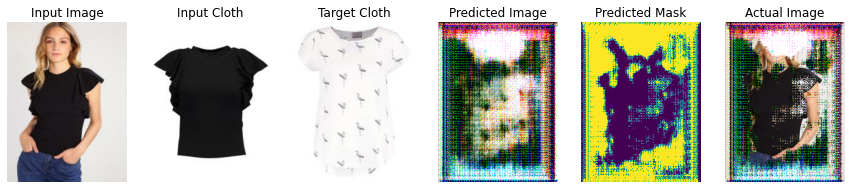

100%|██████████| 1/1 [07:21<00:00, 441.24s/it]


In [44]:
fit(train,1)

In [40]:
while True:
  generate_images()
  display.clear_output(wait=True)

KeyboardInterrupt: ignored